# Hw06 Coding: Debugging and MSTs
In this notebook, we'll introduce some debugging techniques that can help you diagnose and fix errors in your code, and then we'll apply these techniques to debug an implementation of Kruskal's algorithm.

*Note: We hope to give you a formal exposition of debugging techniques that you can use to diagnose and fix errors in your code, both in this course and beyond. However, do note that the tips mentioned here are not exhaustive and are tailored to the context of this course. Please refer to the resources mentioned at the end of this notebook if you'd like to learn more.*

### If you're using Datahub:
* Run the cell below **and restart the kernel if needed**

### If you're running locally:
You'll need to perform some extra setup.
#### First-time setup
* Install Anaconda following the instructions here: https://www.anaconda.com/products/distribution 
* Create a conda environment: `conda create -n cs170 python=3.8`
* Activate the environment: `conda activate cs170`
    * See for more details on creating conda environments https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
* Install pip: `conda install pip`
* Install jupyter: `conda install jupyter`

#### Every time you want to work
* Make sure you've activated the conda environment: `conda activate cs170`
* Launch jupyter: `jupyter notebook` or `jupyter lab` 
* Run the cell below **and restart the kernel if needed**

In [1]:
# Install dependencies
!pip install -r requirements.txt --quiet

In [2]:
import otter

assert (otter.__version__ >= "4.4.1"), "Please reinstall the requirements and restart your kernel."

grader = otter.Notebook("hw06.ipynb")
import numpy as np
from numpy.random import randint
from time import time
import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy.random as random

rng_seed = 0

## Representing Graphs in Code (Part 3!!)
We'll use a similar weighted adjacency list representation to last week. However, in this assignment, our graphs are undirected. Practically speaking, this means that in our adjacency list, each undirected edge is represented by two directed edges.

So we can represent the undirected edge $(u, v)$ with weight $w$ by storing the tuple `(v, w)`  in `adj_list[u]` *and* the tuple `(u, w)` in `adj_list[v]`.

In [3]:
# Do not modify the next three functions!
def generate_adj_list(n, edge_list):
    """
    args:
        n:int = number of nodes in the graph. The nodes are labelled with integers 0 through n-1
        edge_list:List[Tuple[int,int,int]] = edge list where each tuple (u,v,w) represents the undirected 
            and weighted edge (u,v,w) in the graph
    return:
        A List[List[Tuple[int, int]]] representing the adjacency list 
    """
    adj_list = [[] for i in range(n)] 
    for u, v, w in edge_list:
        adj_list[u].append((v, w))
        adj_list[v].append((u, w))
    for nodes in adj_list:
        nodes.sort()
    return adj_list

def adj_list_to_nx(adj_list):
    """Creates a networkx graph from an adjacency list

    args:
        adj_list (List[List[Tuple[int, int]]]): the adjacency list of a graph
    returns:
        nx.Graph: a networkx graph. Expects weights to be represented using the 'weight' attribute on edges
    """
    G = nx.Graph()
    for u in range(len(adj_list)):
        for v, w in adj_list[u]:
            G.add_edge(u, v, weight=w)
    return G

def nx_to_adj_list(G):
    """Creates an adjacency list from a networkx graph

    args:
        G (nx.Graph): a networkx graph. Expects weights to be represented using the 'weight' attribute on edges
    returns:
        List[List[Tuple[int, int]]]: the adjacency list of G
    """
    return generate_adj_list(G.number_of_nodes(), G.edges.data('weight'))

# Feel free to modify anything below this line
def draw_graph(adj_list):
    """Utility method for visualizing undirected graphs

    args:
        adj_list (List[List[Tuple[int, int]]]): adjacency list of the graph given by generate_adj_list
    """
    G = adj_list_to_nx(adj_list)

    pos = nx.spring_layout(G)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), verticalalignment='top')
    nx.draw(G, pos, with_labels=True)

## The Task
Consider the following task:

Now it is time to implement Kruskal's algorithm! Implement the following function which returns a list of edges representing a minimum spanning tree. If the graph is not connected, you should return the empty list `[]`.

Note that nodes in the graph are labelled with integers between 0 and n-1.

You may not use any built in libraries or modules to compute the MST.

Now, suppose your friend wrote the following code to implement Union Find and Kruskal's algorithm:

**Note: do not assume the correctness of any of the following code or comments as they may contain bugs.** Instead, go off of the task description provided above and use your own tests/debugging procedures to locate errors.

In [8]:
class UnionFind:
    def __init__(self, n):
        '''
        args:
            n:int = number of nodes in the union find data structures. Nodes are index 
                by integers between 0 and n-1
        '''
        self.n = n
        self.parents = [i for i in range(n)]
        self.rank = [1]*n
    
    def find(self, i):
        '''
        args:
            i:int = index of some node
        returns:
            an integer representing the root of the set in which node i belongs
        '''
        assert i >= 0 and i <= self.n-1, f"Node {i} is not in the data structure. Only nodes {0} through {self.n-1} exist."
        if i != self.parents[i]:
            self.parents[i] = self.find(self.parents[i])
        return self.parents[i]
    
    def union(self, pi, pj):
        '''
        args:
            pi:int = index of some parent node
            pj:int = index of some parent node    
        '''
        assert pi >= 0 and pi <= self.n-1, f"Node {pi} is not in the data structure. Only nodes {0} through {self.n-1} exist."
        assert pj >= 0 and pj <= self.n-1, f"Node {pj} is not in the data structure. Only nodes {0} through {self.n-1} exist."

        if pi != pj:
            if self.rank[pi] < self.rank[pj]:
                self.parents[pi] = pj
            elif self.rank[pi] > self.rank[pj]:
                self.parents[pi] = pi
            else:
                self.parents[pi] = pj
                self.rank[pi] += 1
                

In [5]:
def kruskal(G):
    """
    args:
        G:List[List[Tuple[int,int]]] = The input graph G is represented as a list of n lists, where 
            each element of the list G[u] (where u is an integer between 0 and n-1) is a tuple with 
            2 elements: (v, w) means there's an edge $(u,v)$ of weight $w$.
            
            You can assume that we will only feed simple graphs G to your implementation as input. 
            Also G is undirected, so if an edge (u,v) exists it will be found in both G[u] and G[v].
    
    returns:
        List[Tuple[int,int]] = a list of edges belonging to an MST or [] if the graph is not connected
    """
    # creates an adjacency list and sorts it
    T = []
    edges = []
    
    for u in range(len(G)):
        for w, v in G[u]:
            edges.append((w, u, v))
    edges.sort()
    
    UF = UnionFind(len(G))
                         
    for e in edges:
                         
        # addes edges that aren't in the same connected component
        u,v = e[1],e[2]
        w = e[0]
        if UF.find(u) != UF.find(v):
            UF.union(u,v)
            # T.append((u,v))
            T.append((u, v, w))
            
    if len(T) != len(G) - 1:
        return []

    return T

However, this code doesn't work quite right. Now, we'll look at a systematic way to isolate and debug the issues.

## 1: Reproduce the error
Before we start debugging, it helps to diagnose the issue so we know where to start looking.
Let's try to come up with some small test cases to determine why the code isn't working. Let's start by trying to come up with a small graph where the code fails to give the right answer.

It may help to try and draw some graphs on paper, or if you are familiar with [Networkx](https://networkx.org/documentation/stable/tutorial.html), you can use Networkx methods and convert the graph to an adjacency list using `nx_to_adj_list` provided above.

Sometimes, you can use intuition to come up with a test case that might expose certain edge cases. Otherwise, constructing random inputs until you find one that breaks the code can also work. Networkx and NumPy can be helpful for generating random inputs.

> **Task 1:** Come up with a small graph where the code fails to give the right answer. You can represent the graph as an adjacency list. Your graph should have at most 10 vertices.

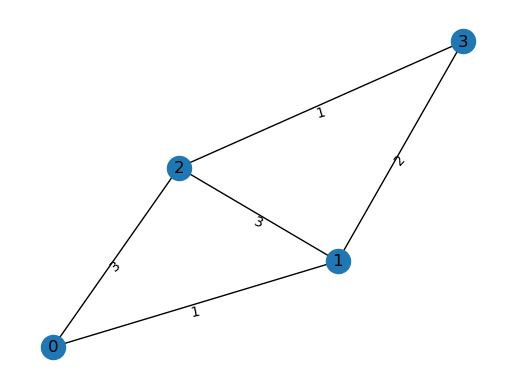

In [22]:
# TODO: construct your graph here

G_connected = nx.Graph()
edges_with_weights = [(0, 1, 1), (0, 2, 3), (1, 2, 3), (1, 3, 2), (2, 3, 1)]
G_connected.add_weighted_edges_from(edges_with_weights)
G_a = nx_to_adj_list(G_connected)
draw_graph(G_a)
test_graph = G_a

### Testing the algorithm using your test case
You can use the following cell to visualize your graph.

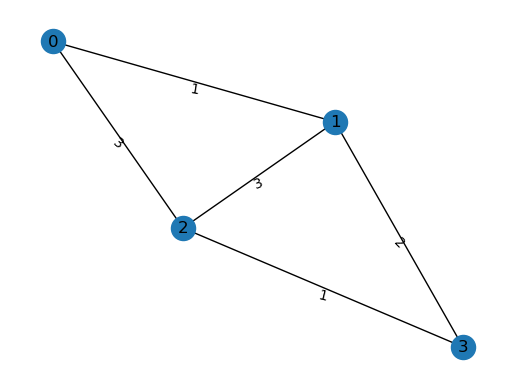

In [23]:
draw_graph(test_graph)

Additionally, we provide the following helper code to check whether an MST is correct.

In [24]:
def check_mst(adj_list, T):
    '''Verifies whether T is a minimum spanning tree of G
    args:
        adj_list:List[List[Tuple[int, int]]] = adjacency list of the graph
        T:List[Tuple[int, int]] = list of edges in the MST
    '''
    G = adj_list_to_nx(adj_list)
    
    nx_tree = nx.Graph()
    nx_tree.add_nodes_from(G.nodes)

    for u, v in T:
        nx_tree.add_edge(u, v)

    if not nx.is_connected(G) and T != []:
        return False
    
    if not nx.is_tree(nx_tree):
        return False
    
    if nx_tree.number_of_edges() != G.number_of_nodes() - 1:
        return False
    
    mst = nx.minimum_spanning_tree(G)

    T_weight = sum([G[u][v]['weight'] for u, v, in G.edges() if (u, v) in T or (v, u) in T])
    mst_weight = sum([w for u, v, w in mst.edges(data='weight')])

    return T_weight == mst_weight

Now, verify that the buggy code fails on your test case below.

_Points:_ 1

In [25]:
grader.check("q1")

q1 results: All test cases passed!

## 2. Isolating the Issue
Now that we have some inputs that we can use to reproduce the error, we can try to isolate the issue and determine where the bug is. To do this, we probably want to use some method to figure out what the code is doing. We can use print statements, or we can use a debugger.

### Using print statements
We can add print statements to our code at specific points to figure out certain things about the program state. We might want to know the specific values of certain variables, or whether certain branches of an if-else statement are being executed. It's usually a good idea to ensure print statements are descriptive enough to help you know what's going on, (e.g. label variables if you print multiple things at once), and to think about where you put print statements so you don't get overwhelmed with output.

Advantages of print statement debugging:
* Pretty much always works, regardless of language/IDE
* Doesn't require any setup

Disadvantages of print statement debugging:
* Requires modification of the code
* Output can become overwhelming quickly
* Can slow down the program
* Printing too much can cause the kernel to crash
* Need to remember to remove print statements when you're done

### Using a debugger
If you use JupyterLab, you can use the built-in debugger (see [this tutorial](https://jupyterlab.readthedocs.io/en/latest/user/debugger.html)). 
VSCode and other IDEs also tend to have good debuggers. See [this tutorial](https://code.visualstudio.com/docs/datascience/jupyter-notebooks#_debug-a-jupyter-notebook) for how to use the VSCode debugger with Jupyter notebooks. If you use another IDE, you can find out more by checking the documentation for your IDE.

Generally, we want to add breakpoints at important points in our code and then step through our code line-by-line and verify that the program state is what we expect it to be. We can also inspect the values of variables at each step.

Advantages of using a debugger:
* Can step through code line-by-line
* Can inspect the values of variables at each step
* Can check *any* variable value at *any* point in the program, and can stop and examine outputs *wherever you want*. This is extremely powerful!

Using a debugger might take some time to get used to, but it's very helpful in debugging effectively.

As stated in the MIT 6.031 course notes:
> **A debugger is a powerful tool that rewards the effort put into learning how to use it.**

<!-- BEGIN QUESTION -->

Now that we have the tools to check the program output at every step, return to the function above and use these tools to debug the function. In this case, let's try to pinpoint the first time the function adds an incorrect edge to the MST. We'd like you to use some debugging or probing method to figure out what's going on, rather than just reading through the code and guessing where the bug is.

> **Task 2 (manually graded):** Briefly describe (1-2 sentences) what method you used to debug the function, and write down the first incorrect edge that the function added to the tree.


_Points:_ 2

I used print statements and the first incorrect edge that was added to the MST given my graph was edge (3, 2) which created a cycle.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 3. Figuring out the cause of the error
Now that we've found the exact moment where the code starts to fail, we can investigate the root cause of the issue. This might involve a **divide and conquer** (heh) approach, where we try to isolate the issue to a specific part of the code. The debugging techniques we used in step 2 can be helpful here.

Some questions to ask yourself:
* When the code makes the wrong move, what are the variables involved? Are they what you expect them to be?
* If some variables are wrong, where are these variables computed? Are they calculated correctly? (you can investigate this by using the debugging techniques from step 2)

> **Task 3 (manually graded):** Briefly mention any variables that were incorrect when the code made the wrong move, and describe what was wrong with them. Then, describe how you might fix this issue (1 sentence).


_Points:_ 1

In the line in kruskal function edges.append((w, u, v)) we were adding the weight as an edge from w to u and the weight was being added as vertex v. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 4. Make the fix
Now that we've pinpointed the problem, we can attempt a fix. When we fix things, it's important to be systematic and change **one thing at a time**. It can also be useful to maintain a record of what you changed and why, in case your fix doesn't work and you need to go back to a previous version.

> **Task 4 (manually graded):** (1 sentence). Implement a fix in the code below Task 5. Describe the one thing you changed in the code to fix the issue you identified in Task 3.


_Points:_ 1

I swapped v and w in for w, v in G[u] so that we are correctly adding (w, u, v) to edges, and the line u,v = e[1],e[2] is now correct.

<!-- END QUESTION -->

## 5. Repeat
After making a fix, it's important to test the code again to ensure that the fix worked. If the fix didn't work, we can go back to step 3 and try to figure out what went wrong, and repeat the process until the code works as expected.

> **Task 5a:** Implement your fix from part 4 on the code below and repeat this process until the code works as expected. 

We will not provide formal local tests for this task, but we will check your new function for correctness on Gradescope. 

**We will be imposing a rate limit of 1 submission every 10 minutes on Gradescope, so you should verify correctness locally on your own before submitting.**

*Hint: it may be helpful to come up with a few handmade test cases and a large number of randomly generated test cases to ensure your implementation is correct.*

In [26]:
class UnionFind:
    def __init__(self, n):
        '''
        args:
            n:int = number of nodes in the union find data structures. Nodes are index 
                by integers between 0 and n-1
        '''
        self.n = n
        self.parents = [i for i in range(n)]
        self.rank = [1]*n
    
    def find(self, i):
        '''
        args:
            i:int = index of some node
        returns:
            an integer representing the root of the set in which node i belongs
        '''
        assert i >= 0 and i <= self.n-1, f"Node {i} is not in the data structure. Only nodes {0} through {self.n-1} exist."
        if i != self.parents[i]:
            i = self.find(self.parents[i])
        # while i != self.parents[i]:
        #     i = self.parents[i]
        return i
    
    def union(self, pi, pj):
        '''
        args:
            pi:int = index of some parent node
            pj:int = index of some parent node    
        '''
        assert pi >= 0 and pi <= self.n-1, f"Node {pi} is not in the data structure. Only nodes {0} through {self.n-1} exist."
        assert pj >= 0 and pj <= self.n-1, f"Node {pj} is not in the data structure. Only nodes {0} through {self.n-1} exist."
        x = self.find(pi)
        y = self.find(pj)
        if x == y: return
        if self.rank[x] > self.rank[y]:
            self.parents[y] = x
        else:
            self.parents[x] = y
            if self.rank[x] == self.rank[y]: 
                self.rank[y] += 1

In [27]:
def kruskal(G):
    """
    args:
        G:List[List[Tuple[int,int]]] = The input graph G is represented as a list of n lists, where 
            each element of the list G[u] (where u is an integer between 0 and n-1) is a tuple with 
            2 elements: (v, w) means there's an edge $(u,v)$ of weight $w$.
            
            You can assume that we will only feed simple graphs G to your implementation as input. 
            Also G is undirected, so if an edge (u,v) exists it will be found in both G[u] and G[v].
    
    returns:
        List[Tuple[int,int]] = a list of edges belonging to an MST or [] if the graph is not connected
    """
    T = []
    edges = []
    
    for u in range(len(G)):
        for v, w in G[u]:
            edges.append((w, u, v))
    edges.sort()
    
    UF = UnionFind(len(G))
                         
    for e in edges:
        u,v = e[1],e[2]
        if UF.find(u) != UF.find(v):
            UF.union(u,v)
            T.append((u,v))

    if len(T) != len(G) - 1:
        return []

    return T


### Testing Locally
Before submitting to Gradescope, you should probably test your implementation to make sure it works. You can use the following cell to do so. Any test cases you write here will not be graded.

*Hint: feel free to copy/paste code from anywhere in this notebook or even from previous weeks' notebooks to help you test your code.*

_Points:_ 2

True

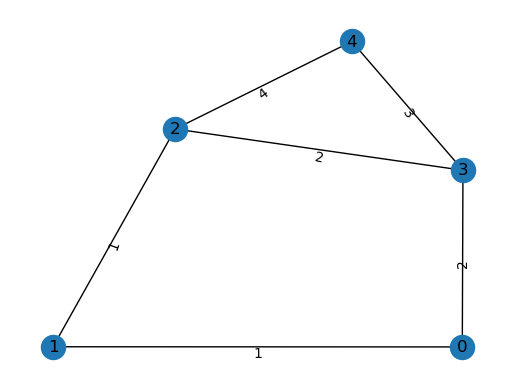

In [28]:
# TODO: test your implementation here
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_weighted_edges_from([(1, 0, 1), 
                           (0, 3, 2), 
                           (3, 2, 2), 
                           (3, 4, 3), 
                           (4, 2, 4), 
                           (2, 1, 1), 
                           ])
G_adj = nx_to_adj_list(G)
draw_graph(G_adj)
test_graph = kruskal(G_adj)
test_graph
check_mst(G_adj, test_graph)

In [29]:
grader.check("q5a")

Testing correctness: 100%|██████████| 99/99 [00:05<00:00, 16.93it/s] 


q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

> **Task 5b (manually graded):** If you noticed additional issues after making the fix in part 4, briefly describe them here and what you did to fix them (2-3 sentences per additional issue/fix).

_Points:_ 2

We weren't correctly implementing union function in Union Find Class. In union function we weren't finding the parents of the vertices. I added the line were we find the parents. After finding this mistake, I worked under the assumption that everything could potentially be wrong in UnionFind class and implemented everything again using the pseudo code from textbook.

<!-- END QUESTION -->

# References
[1] MIT 6.031: Software Construction, Spring 2022. Reading 13: Debugging. https://web.mit.edu/6.031/www/sp22/classes/13-debugging/

[2] <u>Debugging: The Nine Indispensable Rules for Finding Even the Most Elusive Software and Hardware Problems</u> by David Agans. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [127]:
grader.export(pdf=False, force_save=True, run_tests=True)

<IPython.core.display.Javascript object>

/Users/jehuzepeda-silva/anaconda3/lib/python3.11/site-packages/otter/check/notebook.py:355: UserWarning: Couldn't automatically save the notebook; we recommend using File > Save & Checkpoint and then re-running this cell. The zip file returned by this call will use the last saved version of this notebook.
  warnings.warn(


Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q5a results: All test cases passed!
